In [6]:
import sys
sys.path.insert(0, "../kitti/")
from util import kitti_label_file_parser, kitti_calib_file_parser, get_corner_2D, load_tf_image, draw_corner_2D
from util import AVG_HEIGT, AVG_WIDTH, AVG_LENTH, P2_tf, ANCHOR_Y_3D_MEAN, KITTI_Object, init_img_plt, draw_birdeyes

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.path import Path
import matplotlib.patches as patches

import torch
import pickle
import numpy as np 
from math import pi, atan2
import random 
import copy
import cv2

ANCHOR_X_STRIDE = 0.7
ANCHOR_Z_STRIDE = 1.5
ANCHOR_NAME = "BEV_anchor"
img_tf = load_tf_image("/home/lab530/KenYu/kitti/training/image_2/000169.png")

# Get anchor_z_step
anchor_z_step = []
z1 = 80
v1 = (ANCHOR_Y_3D_MEAN - AVG_HEIGT/2.0)*P2_tf[1, 1]/z1
while v1 < 288:
    anchor_z_step.append(z1)
    dz = min(z1 - ( v1*z1 / (v1 + 16) ), ANCHOR_Z_STRIDE)
    z1 -= dz
    v1 = (ANCHOR_Y_3D_MEAN - AVG_HEIGT/2.0)*P2_tf[1, 1]/z1

anchors = []
anchors_untransform = []
for z3d in anchor_z_step:
    fx = P2_tf[0, 0]
    
    # Get anchor_x_stride
    anchor_x_stride = z3d*16/fx
    anchor_x_stride = min(anchor_x_stride, ANCHOR_X_STRIDE)# Saturation anchor_x_stride

    for x3d in np.arange(-30, 30.1, anchor_x_stride):
        for rot_y in [0, -pi/2]:
            # 'category, truncated, occluded alpha, xmin, ymin, xmax, ymax, height, width, length, x3d, y3d, z3d, rot_y, score]
            # 1         2          3        4      5     6     7     8     9       10     11      12   13   14   15     16
            str_line = f"Car NA NA NA NA NA NA NA {AVG_HEIGT} {AVG_WIDTH} {AVG_LENTH} {x3d} {ANCHOR_Y_3D_MEAN} {z3d} {rot_y} NA"
            anchor = KITTI_Object(str_line, is_transform = True)
            
            # TODO, truncated object might not able to be captured by anchors because its (cx, cy) is not in image
            if 0 <= anchor.cx_f_index < 80 and 0 <= anchor.cy_f_index < 18:
                anchors.append(anchor)
                # anchors_untransform.append(anchor_untransform)
                # img_tf = cv2.circle(img_tf, (int(anchors[-1].cx), int(anchors[-1].cy)), radius=1, color=(0, 0, 255), thickness=1)
            # draw_corner_2D(ax[0], anchors[-1].corner_2D)
            # draw_2Dbox(ax[1], (anchors[-1].xmin, anchors[-1].ymin, anchors[-1].xmax, anchors[-1].ymax))
            # draw_birdeyes(ax[2], anchors[-1])
print(f"number of anchor in total = {len(anchors)}")


# Anchor to [N, 12] format
# sampled_gt_bboxes = [x1, y1, x2, y2, cls_index, cx, cy , cz, w, h, l , alpha, x3d, y3d, z3d, rot_y]
#                       0  1   2   3   4          5   6    7   8  9  10, 11   , 12   ,13, 14 , 15



number of anchor in total = 9384


# Draw BEV Anchor

Most concentrated features pixel has 128.0 anchors
Total anchor in heatmap = 9384.0
There are 402 pixel that don't have anchors


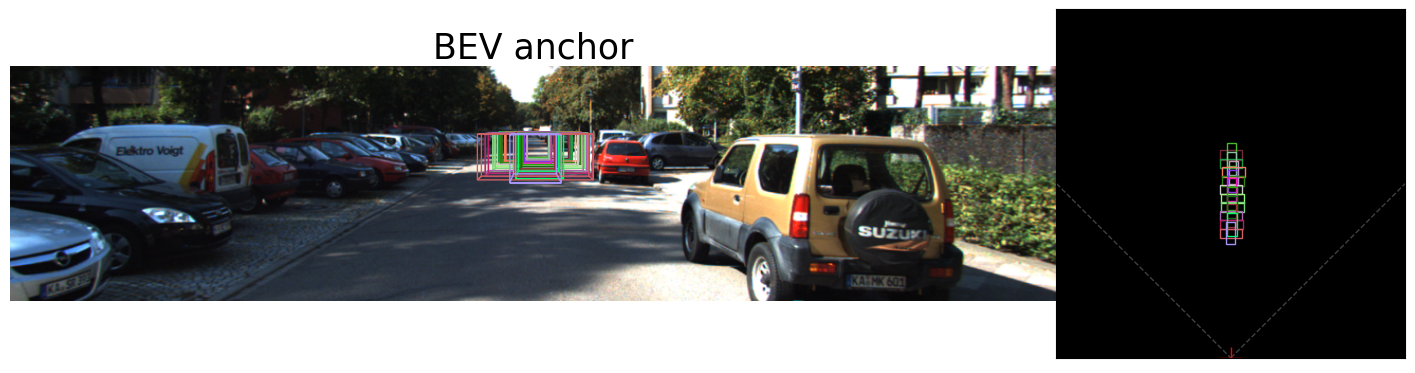

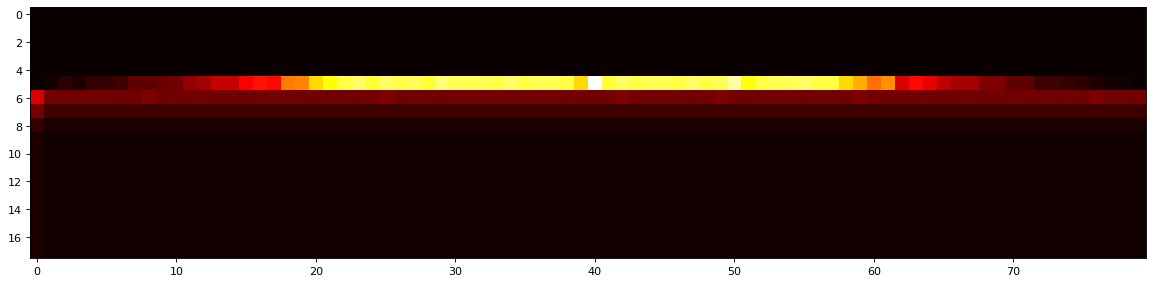

In [7]:
axs = init_img_plt([img_tf], titles = ["BEV anchor"])

# Draw heat map
heat_data = np.zeros(shape=(18, 80))
for anchor in anchors:
    if 0 <= anchor.cx_f_index < 80 and 0 <= anchor.cy_f_index < 18:
        heat_data[anchor.cy_f_index, anchor.cx_f_index] += 1
print(f"Most concentrated features pixel has {heat_data.max()} anchors" )
print(f"Total anchor in heatmap = {heat_data.sum()}")
print(f"There are {18*80 - np.count_nonzero(heat_data)} pixel that don't have anchors")
plt.figure(figsize=(18, 80), dpi=80)
plt.imshow(heat_data, cmap='hot', interpolation='nearest')

# Draw anchor in specific anchor
SHOW_COOR = (6, 40)
for a in anchors:
    if int(a.cx_f_index) == SHOW_COOR[1] and int(a.cy_f_index) == SHOW_COOR[0]:
        rnd_color = (random.random(), random.random(), random.random())
        draw_corner_2D(axs[0][0], a.corner_2D, color = rnd_color, is_draw_front = False)
        draw_birdeyes (axs[0][1], a, color = rnd_color)



# Output Anchor

In [8]:
# Convert anchor to tensor 
anchors_tensor = []
for a in anchors:
    anchors_tensor.append([a.xmin, a.ymin, a.xmax, a.ymax, 0, 
                           a.cx, a.cy, a.cz, a.w, a.h, a.l, a.alpha,
                           a.x3d, a.y3d, a.z3d, a.rot_y])
anchors_tensor = torch.FloatTensor(anchors_tensor)
print(f"anchors_tensor.shape = {anchors_tensor.shape}") # [14284, 12]

###############################
#### OUtput anchor to file ####
###############################

with open(f"pkl/{ANCHOR_NAME}.pkl", 'wb') as f:
    pickle.dump(anchors_tensor, f)
print(f"Write anchor result to {ANCHOR_NAME}.pkl")

# Get heat_data
max_n_anchor = int(heat_data.max())
anchor_map = []
for i in range(18):
    for j in range(80):
        anchor_map += ( [True for _ in range(int(heat_data[i, j]))] + [False for _ in range(max_n_anchor - int(heat_data[i, j]))] )
anchor_map = torch.tensor(anchor_map)

print( torch.count_nonzero(anchor_map) )
print(anchor_map.shape) # [109440] 9332 trues

with open(f"pkl/{ANCHOR_NAME}_map.pkl", 'wb') as f:
    pickle.dump(anchor_map, f)
print(f"Write anchor result to {ANCHOR_NAME}_map.pkl")


anchors_tensor.shape = torch.Size([9384, 16])
Write anchor result to BEV_anchor.pkl
tensor(9384)
torch.Size([184320])
Write anchor result to BEV_anchor_map.pkl
